In [3]:
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve


In [4]:
import os
print(os.listdir("../input"))

% matplotlib inline

['hmnist_64_64_L.csv', 'Kather_texture_2016_larger_images_10', 'kather_texture_2016_larger_images_10', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'Kather_texture_2016_image_tiles_5000', 'kather_texture_2016_image_tiles_5000', 'hmnist_28_28_L.csv']


In [5]:
path= Path('../input/kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/')
csv_file='../input/hmnist_28_28_RGB.csv'

In [6]:
df= pd.read_csv(csv_file)
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,156,73,106,169,79,115,199,131,161,190,142,178,129,73,120,76,24,69,175,119,153,208,169,201,197,145,181,198,139,172,157,90,134,153,99,138,219,185,202,147,...,96,41,81,176,103,135,186,112,151,184,98,144,156,74,121,119,48,88,115,47,92,118,50,96,204,126,156,169,107,150,148,67,117,191,102,148,199,137,172,2
1,139,33,55,139,32,58,143,35,52,159,39,52,162,43,61,111,31,56,90,23,52,133,36,61,182,48,69,162,38,59,164,44,64,104,25,47,80,18,42,134,...,136,30,57,118,28,58,119,28,57,118,27,53,122,28,51,133,34,55,148,40,61,161,43,65,170,41,62,169,43,67,159,39,65,155,38,59,148,38,60,2
2,186,96,135,193,108,148,176,91,137,189,114,148,210,149,176,168,81,122,184,97,143,170,87,137,91,38,92,153,78,120,154,58,87,118,23,40,151,47,76,174,...,171,76,122,144,61,108,132,64,110,106,46,92,134,64,109,156,70,113,187,118,159,166,93,138,198,122,152,191,113,152,227,175,199,195,120,158,155,66,108,2
3,139,50,84,158,55,93,185,61,88,188,66,97,193,83,122,181,62,90,188,59,80,114,40,75,111,37,73,171,54,79,182,55,80,176,51,73,170,50,67,217,...,152,52,87,202,84,117,216,114,148,219,122,149,207,94,124,182,73,106,180,59,82,184,63,89,139,39,66,171,57,78,206,79,110,160,48,73,117,34,63,2
4,197,130,162,182,119,155,171,93,135,181,105,147,166,80,124,192,100,134,175,89,127,146,73,117,142,76,124,127,69,115,122,62,111,182,114,152,200,137,170,187,...,190,100,141,171,69,106,170,75,115,198,102,139,183,84,117,186,87,126,186,109,150,205,163,193,208,183,205,223,203,219,204,180,201,190,126,162,198,132,165,2


In [9]:
# Split the dataset into training and testing sets
train_ratio = 0.8
train_size = int(train_ratio * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

In [10]:
# Print the size of the training and testing sets
print("Size of training set:", len(train_df))
print("Size of testing set:", len(test_df))

Size of training set: 4000
Size of testing set: 1000


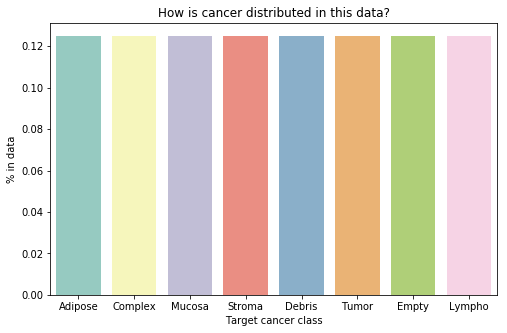

In [51]:
class_names = {1: "Tumor", 2: "Stroma", 3: "Complex", 4: "Lympho",
               5: "Debris", 6: "Mucosa", 7: "Adipose", 8: "Empty"}
class_numbers = {"Tumor": 1, "Stroma": 2, "Complex": 3, "Lympho": 4,
               "Debris": 5, "Mucosa": 6, "Adipose": 7, "Empty": 8}
class_colors = {1: "Red", 2: "Orange", 3: "Gold", 4: "Limegreen",
                5: "Mediumseagreen", 6: "Darkturquoise", 7: "Steelblue", 8: "Purple"}

label_percentage = df.label.value_counts() / df.shape[0]
class_index = [class_names[idx] for idx in label_percentage.index.values]

plt.figure(figsize=(8,5))
sns.barplot(x=class_index, y=label_percentage.values, palette="Set3");
plt.ylabel("% in data");
plt.xlabel("Target cancer class");
plt.title("How is cancer distributed in this data?");

AttributeError: Unknown property ticks

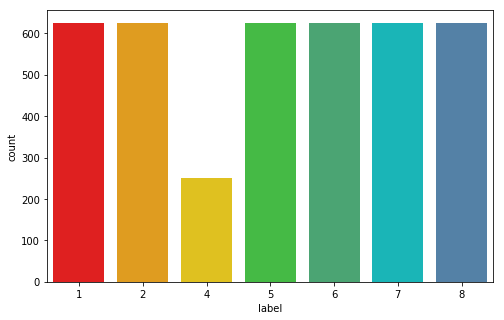

In [52]:
# Data analysis
# Count plot of class distribution in the training set
plt.figure(figsize=(8, 5))
sns.countplot(x=train_df['label'], palette=class_colors.values())
plt.xticks(ticks=list(class_names.keys()), labels=class_names.values(), rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.show()

AttributeError: Unknown property ticks

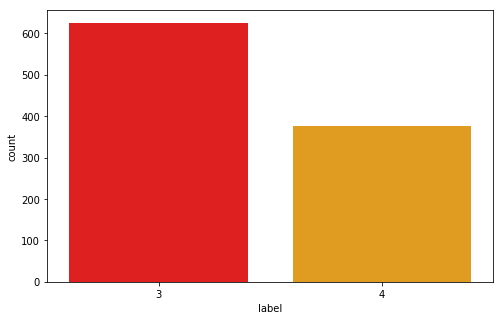

In [53]:
# Count plot of class distribution in the testing set
plt.figure(figsize=(8, 5))
sns.countplot(x=test_df['label'], palette=class_colors.values())
plt.xticks(ticks=list(class_names.keys()), labels=class_names.values(), rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Testing Set")
plt.show()

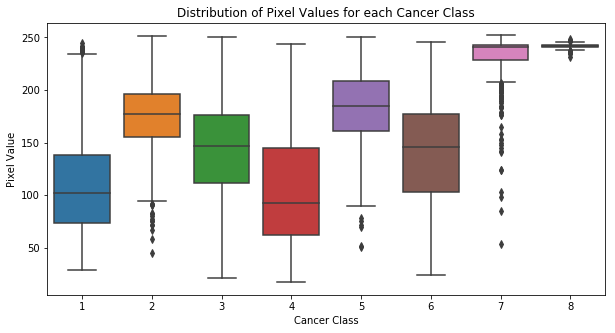

In [54]:
# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='pixel0000', data=df)
plt.xlabel('Cancer Class')
plt.ylabel('Pixel Value')
plt.title('Distribution of Pixel Values for each Cancer Class')
plt.show()

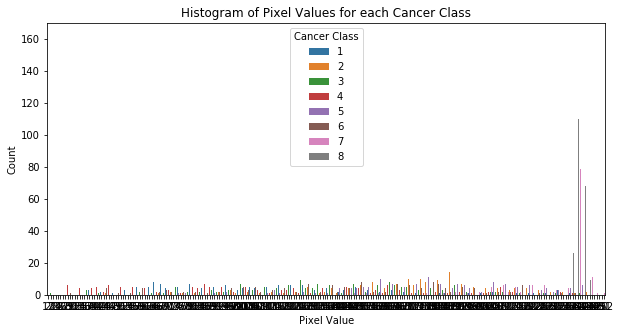

In [57]:
# Histogram
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='pixel0000', hue='label')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.title('Histogram of Pixel Values for each Cancer Class')
plt.legend(title='Cancer Class')
plt.show()

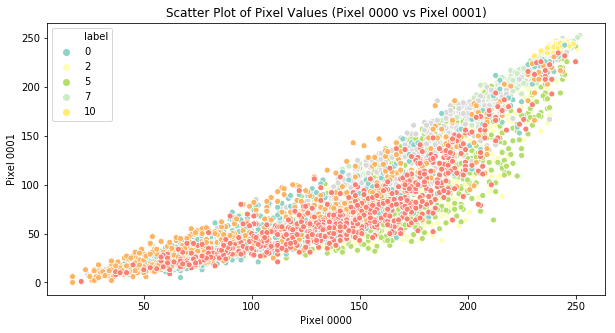

In [58]:
# scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='pixel0000', y='pixel0001', hue='label', palette='Set3')
plt.xlabel('Pixel 0000')
plt.ylabel('Pixel 0001')
plt.title('Scatter Plot of Pixel Values (Pixel 0000 vs Pixel 0001)')
plt.show()

In [13]:
tfms=get_transforms(flip_vert=True, max_warp=0.)

In [14]:
data = (ImageItemList.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=150)
        .databunch(num_workers=2, bs=32))

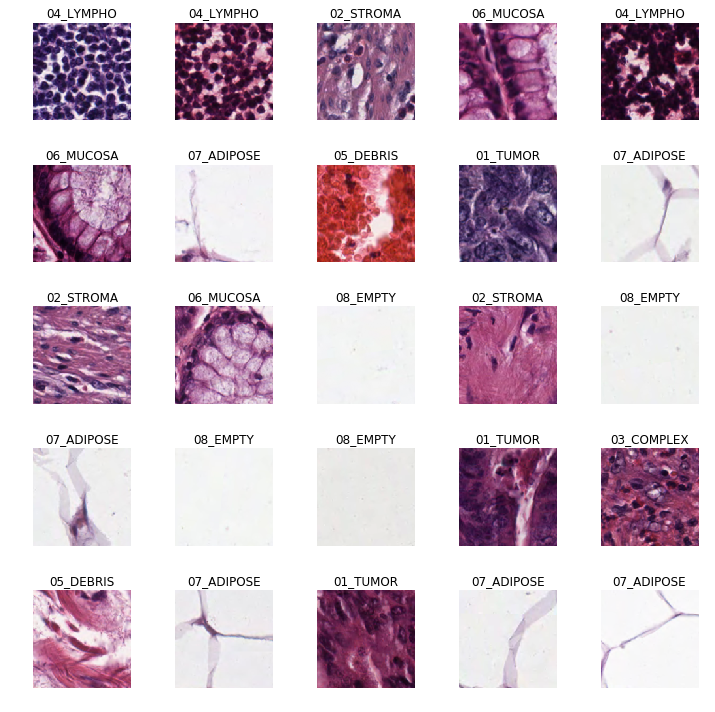

In [15]:
data.show_batch(row=3, figsize=(10,10))

## Model 

**CNN**

In [16]:
learner= create_cnn(data, models.resnet34, metrics=[accuracy], model_dir='/tmp/models/')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 76909632.78it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


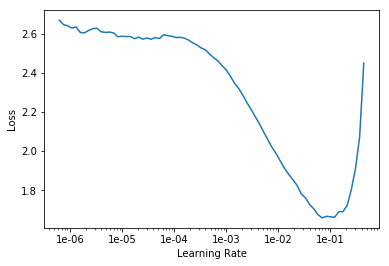

In [17]:
learner.lr_find()
learner.recorder.plot()

****Learning rate = 0.001****

In [16]:
lr=0.001
learner.fit_one_cycle(50, lr)

epoch,train_loss,valid_loss,accuracy
1,1.909047,1.350882,0.522000
2,1.315745,0.847251,0.724000
3,0.892286,0.558123,0.829000
4,0.659118,0.411560,0.861000
5,0.489379,0.340726,0.885000
6,0.438057,0.296674,0.905000
7,0.386245,0.248559,0.916000
8,0.327840,0.230422,0.926000
9,0.315940,0.213596,0.935000
10,0.310119,0.205238,0.942000


In [17]:
learner.save('stage-1')

In [18]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


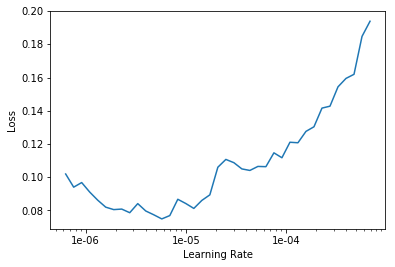

In [20]:
learner.lr_find()
learner.recorder.plot()

In [21]:
learner.fit_one_cycle(50,  6.25e-6)

epoch,train_loss,valid_loss,accuracy
1,0.086403,0.121265,0.959000
2,0.089085,0.121781,0.956000
3,0.082280,0.120734,0.958000
4,0.085153,0.122938,0.958000
5,0.086479,0.121429,0.961000
6,0.085806,0.120200,0.959000
7,0.076814,0.120222,0.962000
8,0.069773,0.121603,0.960000
9,0.081731,0.113355,0.963000
10,0.070880,0.118779,0.963000


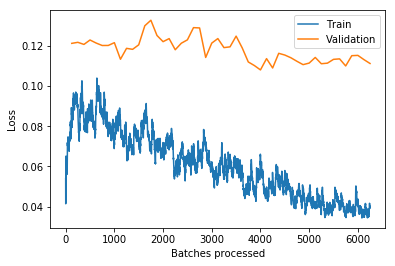

In [22]:
learner.recorder.plot_losses()

In [23]:
learner.save('stage-2')

## Evaluation

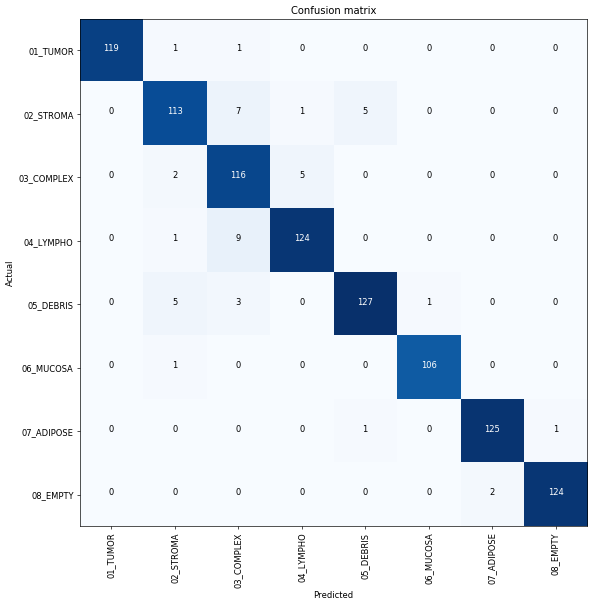

In [60]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [25]:
interp.most_confused()

[('02_STROMA', '03_COMPLEX', 5),
 ('03_COMPLEX', '02_STROMA', 5),
 ('01_TUMOR', '03_COMPLEX', 4),
 ('03_COMPLEX', '04_LYMPHO', 4),
 ('04_LYMPHO', '03_COMPLEX', 4),
 ('02_STROMA', '05_DEBRIS', 2),
 ('03_COMPLEX', '01_TUMOR', 2),
 ('07_ADIPOSE', '08_EMPTY', 2)]

In [26]:
preds, lb=learner.get_preds()

In [27]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(lb.numpy(), preds.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

ROC area is 0.9971256444321894


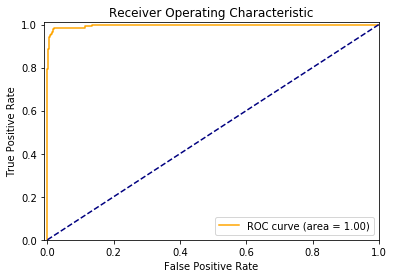

In [28]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

**Learning rate = 0.005**

In [18]:
lr=0.005
learner.fit_one_cycle(50, lr)

epoch,train_loss,valid_loss,accuracy
1,0.983054,0.500266,0.831000
2,0.583194,0.310576,0.894000
3,0.440085,0.235813,0.925000
4,0.388640,0.198101,0.943000
5,0.353211,0.189265,0.937000
6,0.310883,0.213535,0.927000
7,0.285600,0.175552,0.939000
8,0.287311,0.172568,0.948000
9,0.301870,0.244531,0.917000
10,0.297887,0.210904,0.936000


In [19]:
learner.save('stage-3')

In [20]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


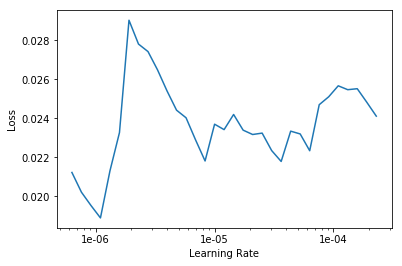

In [22]:
learner.lr_find()
learner.recorder.plot()

In [21]:
learner.fit_one_cycle(50,  3.125e-5)

epoch,train_loss,valid_loss,accuracy
1,0.083628,0.072346,0.972000
2,0.083613,0.071185,0.977000
3,0.087347,0.073169,0.971000
4,0.080803,0.073363,0.973000
5,0.085448,0.076300,0.961000
6,0.091990,0.075203,0.970000
7,0.094909,0.079395,0.974000
8,0.092549,0.087464,0.974000
9,0.091544,0.074031,0.970000
10,0.094824,0.085781,0.973000


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

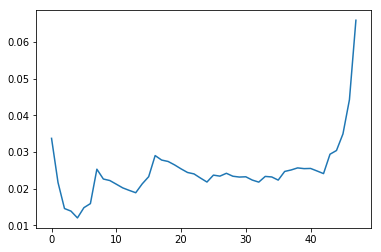

In [24]:
learner.recorder.plot_losses()

In [25]:
learner.save('stage-4')

**Evaluation**

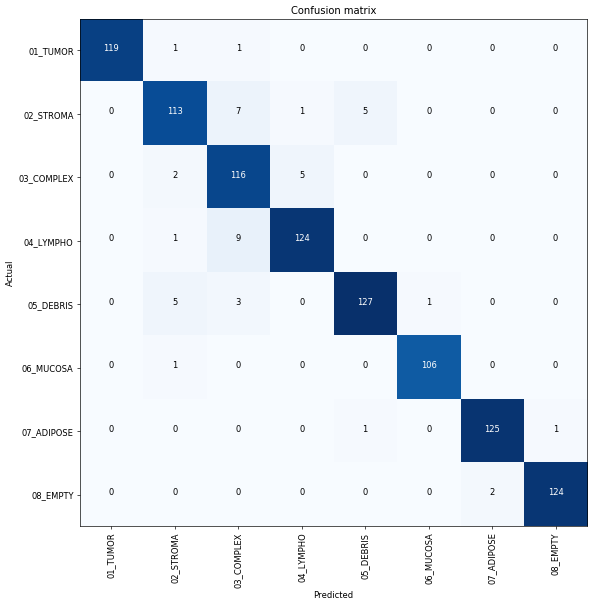

In [61]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [27]:
interp.most_confused()

[('02_STROMA', '03_COMPLEX', 4),
 ('04_LYMPHO', '03_COMPLEX', 4),
 ('01_TUMOR', '03_COMPLEX', 3),
 ('03_COMPLEX', '04_LYMPHO', 2),
 ('07_ADIPOSE', '08_EMPTY', 2)]

In [28]:
preds, lb=learner.get_preds()

In [29]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(lb.numpy(), preds.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

ROC area is 0.999763902509898


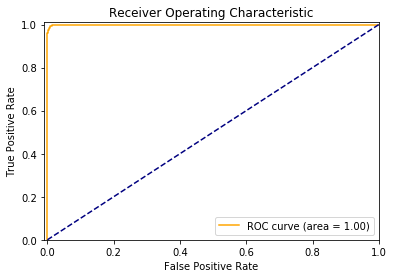

In [30]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

**Learning rate = 0.01**

In [31]:
lr=0.01
learner.fit_one_cycle(50, lr)

epoch,train_loss,valid_loss,accuracy
1,0.598455,0.487082,0.840000
2,0.441511,0.447519,0.830000
3,0.531758,0.469500,0.823000
4,0.559305,1.017561,0.655000
5,0.526884,1.559702,0.675000
6,0.600887,1.244595,0.549000
7,0.563974,0.935929,0.699000
8,0.533538,1.195961,0.597000
9,0.532282,0.989999,0.701000
10,0.571598,0.609394,0.704000


In [32]:
learner.save('stage-5')

In [33]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


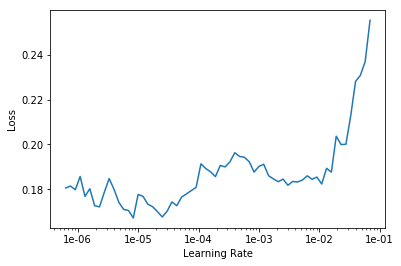

In [34]:
learner.lr_find()
learner.recorder.plot()

In [35]:
learner.fit_one_cycle(50,  6.25e-5)

epoch,train_loss,valid_loss,accuracy
1,0.169953,0.133095,0.953000
2,0.171711,0.130113,0.956000
3,0.167132,0.130535,0.951000
4,0.157767,0.129491,0.956000
5,0.164211,0.128446,0.955000
6,0.176625,0.133547,0.955000
7,0.158280,0.131688,0.955000
8,0.163251,0.129882,0.954000
9,0.160393,0.131645,0.955000
10,0.150571,0.132234,0.956000


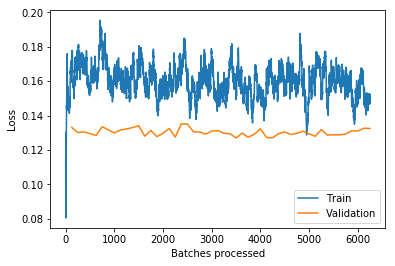

In [36]:
learner.recorder.plot_losses()

In [37]:
learner.save('stage-6')

**Evaluation**

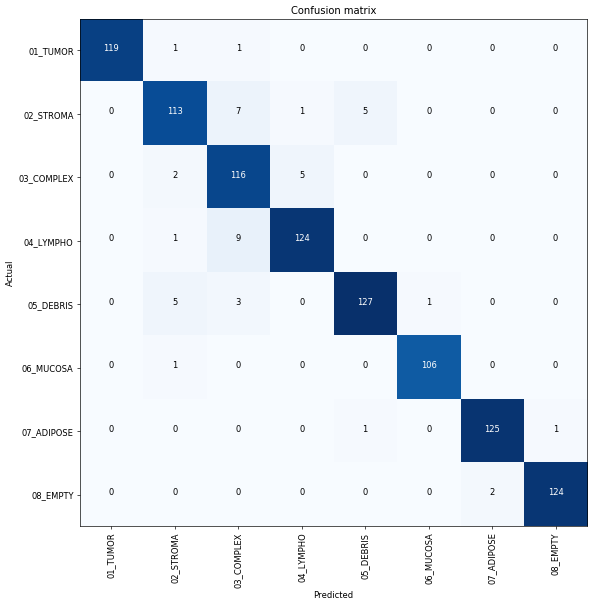

In [62]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [39]:
interp.most_confused()

[('04_LYMPHO', '03_COMPLEX', 9),
 ('02_STROMA', '03_COMPLEX', 7),
 ('02_STROMA', '05_DEBRIS', 5),
 ('03_COMPLEX', '04_LYMPHO', 5),
 ('05_DEBRIS', '02_STROMA', 5),
 ('05_DEBRIS', '03_COMPLEX', 3),
 ('03_COMPLEX', '02_STROMA', 2),
 ('08_EMPTY', '07_ADIPOSE', 2)]

In [40]:
preds, lb=learner.get_preds()

In [41]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(lb.numpy(), preds.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

ROC area is 0.9957048418146817


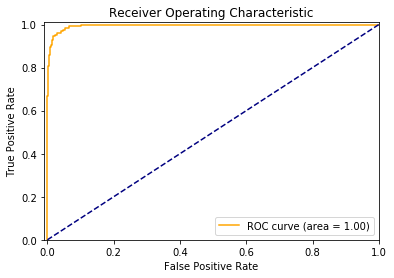

In [42]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [67]:
import pickle

# Get the learner model 
learner = create_cnn(data, models.resnet34, metrics=[accuracy], model_dir='/tmp/models/') 

# Train the model 
learner.fit_one_cycle(50, lr)

# Save the model as a pickle file 
with open('cancer_model.pkl', 'wb') as f:
    pickle.dump(learner, f)

epoch,train_loss,valid_loss,accuracy
1,0.744786,0.352095,0.880000
2,0.496196,0.237471,0.924000
3,0.349051,0.208333,0.924000
4,0.356355,0.212990,0.921000
5,0.333411,0.167288,0.941000
6,0.347448,0.271809,0.900000
7,0.368296,0.352830,0.873000
8,0.369114,0.208556,0.920000
9,0.371696,1.111016,0.737000
10,0.341261,0.375601,0.821000


AttributeError: Can't pickle local object 'Flatten.<locals>.<lambda>'

In [70]:
# Save 
model = learner.model
torch.save(model.state_dict(), 'cancer_model.pth')

In [ ]:
# Load
model = resnet34()
model.load_state_dict(torch.load('cancer_model.pth'))